# Assemble image pathnames and understand class breakdown in dataset

In [1]:
import numpy as np
from glob import glob
import torch

# Note down train, validation and test directories.
train_dir = "data/train"
valid_dir = "data/valid"
test_dir = "data/test"

# Check quantities of train, validation and test images
train_images = np.array(glob("data/train/*/*"))
valid_images = np.array(glob("data/valid/*/*"))
test_images = np.array(glob("data/test/*/*"))

# Check relative percentages of image types
train_images_mel = np.array(glob("data/train/melanoma/*"))
train_images_nev = np.array(glob("data/train/nevus/*"))
train_images_seb = np.array(glob("data/train/seborrheic_keratosis/*"))

valid_images_mel = np.array(glob("data/valid/melanoma/*"))
valid_images_nev = np.array(glob("data/valid/nevus/*"))
valid_images_seb = np.array(glob("data/valid/seborrheic_keratosis/*"))

test_images_mel = np.array(glob("data/test/melanoma/*"))
test_images_nev = np.array(glob("data/test/nevus/*"))
test_images_seb = np.array(glob("data/test/seborrheic_keratosis/*"))

num_train_images = len(train_images)
num_valid_images = len(valid_images)
num_test_images = len(test_images)

print("There are {} training images, {} validation images and {} test images.".format(len(train_images),len(valid_images),len(test_images)))
print("For the training images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(train_images_mel)/len(train_images)*100, mel2=len(train_images_mel),nev=len(train_images_nev)/len(train_images)*100, nev2=len(train_images_nev), seb=len(train_images_seb)/len(train_images)*100, seb2=len(train_images_seb)))
print("For the validation images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(valid_images_mel)/len(valid_images)*100, mel2=len(valid_images_mel),nev=len(valid_images_nev)/len(valid_images)*100, nev2=len(valid_images_nev), seb=len(valid_images_seb)/len(valid_images)*100, seb2=len(valid_images_seb)))
print("For the test images, {mel:=.1f}% ({mel2}) are of melanoma, {nev:=.1f}% ({nev2}) are of nevus and {seb:=.1f}% ({seb2}) are for seborrheic keratosis.".format(mel=len(test_images_mel)/len(test_images)*100, mel2=len(test_images_mel),nev=len(test_images_nev)/len(test_images)*100, nev2=len(test_images_nev), seb=len(test_images_seb)/len(test_images)*100, seb2=len(test_images_seb)))

There are 2000 training images, 150 validation images and 600 test images.
For the training images, 18.7% (374) are of melanoma, 68.6% (1372) are of nevus and 12.7% (254) are for seborrheic keratosis.
For the validation images, 20.0% (30) are of melanoma, 52.0% (78) are of nevus and 28.0% (42) are for seborrheic keratosis.
For the test images, 19.5% (117) are of melanoma, 65.5% (393) are of nevus and 15.0% (90) are for seborrheic keratosis.


In [2]:
# Check for GPU support
use_cuda = torch.cuda.is_available()

In [3]:
# Check to see how many GPUs are available.
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    num_devices = torch.cuda.device_count()
    print("{} GPUs found.".format(num_devices))
else:
    num_devices = 0

8 GPUs found.


# View random images to get a feel for what the dataset looks like

In [4]:
from PIL import Image 
import matplotlib.pyplot as plt    
import matplotlib.gridspec as gridspec
%matplotlib inline 

def plot_some_imgs(num_imgs_to_plot,dataset,dataset_name):
    print("Plotting {} images from dataset {}".format(num_imgs_to_plot,dataset_name))
    fig = plt.figure(figsize = (10,num_imgs_to_plot*2))
    axes = []
    for i in range(num_imgs_to_plot):
        img = Image.open(dataset[np.random.randint(0,len(dataset)-1)])
        axes.append(fig.add_subplot(num_imgs_to_plot/2,2,i+1))
        axes[-1].imshow(img)

Plotting 10 images from dataset /data/train/melanoma


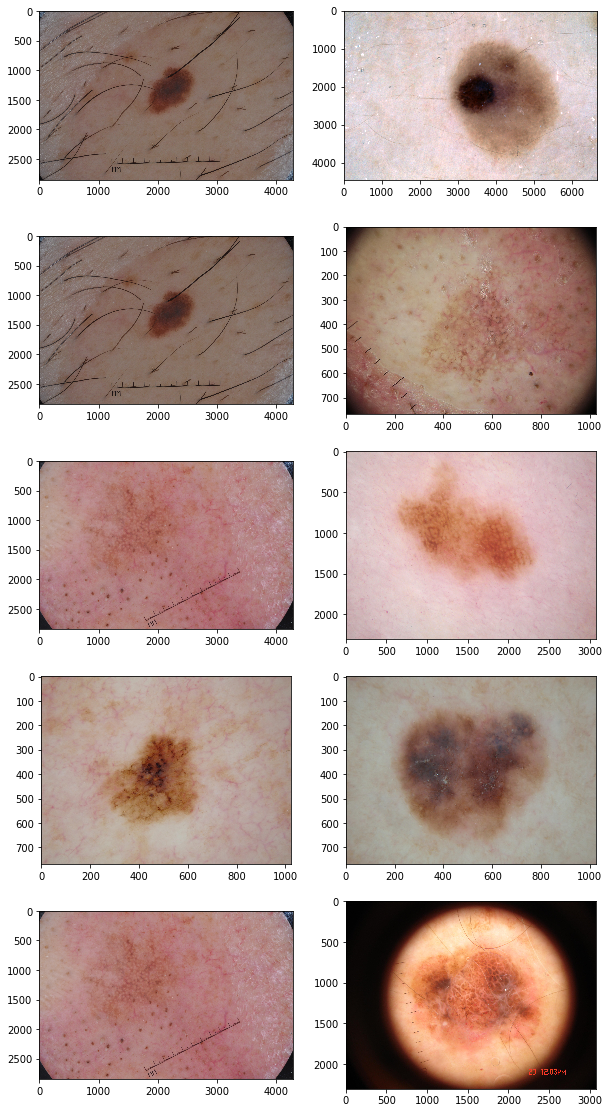

In [5]:
plot_some_imgs(10,train_images_mel,'/data/train/melanoma')

# Model Training

In [6]:
# Decide whether or not to use DALI.
use_dali = 1

In [7]:
# Torch imports.
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

# NVIDIA DALI imports.
if use_dali:
    from nvidia.dali.pipeline import Pipeline
    import nvidia.dali.ops as ops
    import nvidia.dali.types as types
    from nvidia.dali.plugin.pytorch import DALIGenericIterator

# Random imports.
import time
from random import shuffle
import os, sys
import csv

In [8]:
# Define data-viewing function for outputs from DALI pipeline. 
# This assumes no normalization. 
if use_dali:
    # Copied from the DALI example website here: 
    # https://docs.nvidia.com/deeplearning/sdk/dali-developer-guide/docs/examples/getting%20started.html#Pipeline

    #Usage: #view_dalipipe_imgs(images.asCPU(), 8, True)

    def view_dalipipe_imgs(image_batch, batch_size, normalized=False):
        # image_batch - the direct image output of running a DALI pipeline, NOT a DALIGenericIterator
        # batch_size - the number of images in each batch
        # normalized - Boolean flag denoting whether the image has undergone normalization (of the kind used for all pretrained Pytorch models)
        columns = 5
        rows = (batch_size + 1) // (columns)
        fig = plt.figure(figsize = (32,(32 // columns) * rows))
        gs = gridspec.GridSpec(rows, columns)
        # Account for the fact that the image coming in may be sized as HWC vs CHW.
        if image_batch.at(0).shape[0] == 3:
            CHW_flag = 1
        else:
            CHW_flag = 0
        for j in range(rows*columns):
            plt.subplot(gs[j])
            plt.axis("off")
            # If the image is coming in as CHW, it has to be reshaped to HWC
            thisimg = image_batch.at(j)
            if CHW_flag:
                thisimg = np.moveaxis(thisimg,0,-1)
            # If the image has been normalized (assuming Alexnet-type normalization on uint8s ranging from 0 to 255 originally),
            # then de-normalize it.
            if normalized:
                thisimg[:,:,0] = thisimg[:,:,0]*58.395+123.675
                thisimg[:,:,1] = thisimg[:,:,1]*57.12+116.28
                thisimg[:,:,2] = thisimg[:,:,2]*57.375+103.53
                thisimg = np.uint8(thisimg)
            # Plot.
            plt.imshow(thisimg)


In [9]:
# Define the NVIDIA DALI iterator that will feed into the data loading pipeline. 
# The 'image_dir' passed into __init__ is assumed to be a top-level image directory. In other words, there should be no image
# files immediately within that directory. The algorithm below will ignore all image files that are directly within the
# top-level image directory. Rather, the top-level directory should contain exclusively other directories. 

# Each of those sub-directories should contain exclusively .JPEG image files.
# Files within each sub-directory are assumed to belong to the same image class. 

if use_dali:
    class ExternalInputIterator(object):
        def __init__(self, batch_size, image_dir, shuffle_flag):
            self.images_dir = image_dir
            self.files = []
            self.shuffle_flag = shuffle_flag
            self.num_files = 0
            assert isinstance(shuffle_flag, bool)
            # Check which of the entries in the top directory are themselves directories. 
            dirfiles = os.listdir(image_dir)
            num_imgdirs = 0
            self.img_label_dict = dict() # storage denoting which label number corresponds with which label name.

            # NOTE: the below will only grab JPG/JPEG files, and would need to be modified to grab other types of image files.
            # NOTE: even if the below were modified to grab other types of image files, the DALI image processing pipeline
            # uses a JPEG decoder to load in the files, so just keep that in mind.
            for file in dirfiles:
                # Grab the name of every entry in the top directory.
                fullname = os.path.join(image_dir, file)
                # If an entry is a directory, grab the filenames for all the JPG/JPEG files in that directory.
                if os.path.isdir(fullname):
                    imgfiles = os.listdir(fullname)
                    for imgfile in imgfiles:
                        thisimgpath = os.path.join(fullname,imgfile)
                        if os.path.isfile(thisimgpath) and (thisimgpath.lower().endswith(".jpg") or thisimgpath.lower().endswith(".jpeg")):
                            self.img_label_dict[thisimgpath] = num_imgdirs
                            self.files.append(thisimgpath)
                    num_imgdirs += 1
            assert num_imgdirs > 0
            # Store the batch size.
            self.batch_size = batch_size
            # Shuffle the input filenames. 
            if self.shuffle_flag:
                shuffle(self.files)

        def __iter__(self):
            self.i = 0
            self.n = len(self.files)
            return self

        def __next__(self):
            batch = []
            labels = []
            for _ in range(self.batch_size):
                jpeg_filename, label = self.files[self.i], self.img_label_dict[self.files[self.i]]
                self.num_files += 1
                f = open(jpeg_filename, 'rb')
                # Later steps in the DALI image processing pipeline (the resize operation, in particular) expect uint8s. 
                batch.append(np.frombuffer(f.read(), dtype = np.uint8))
                labels.append(np.array([label], dtype = np.uint8))
                self.i = (self.i + 1) % self.n
            return (batch, labels)

        next = __next__



In [10]:
# Define the image processing pipeline for processing training.
# If reproducibility is desired, on the input to super(TrainingPipeline, self), set seed = some # other than -1. 

if use_dali:

    class TrainPipeline(Pipeline):
        def __init__(self, batch_size, num_threads, device_id, image_dir):
            super(TrainPipeline, self).__init__(batch_size, num_threads, device_id)
            self.input = ops.ExternalSource()
            self.input_label = ops.ExternalSource()
            self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
            self.resize = ops.Resize(device="gpu")
            self.resize_rng = ops.Uniform(range = (256,512))
            self.crop = ops.Crop(device="gpu", crop=(224,224))
            self.rotate = ops.Rotate(device="gpu") # Need to specify angle
            self.angle_rng = ops.Uniform(range = (-45.0,45.0))
            self.coin = ops.CoinFlip(probability=0.5)
            self.vertflip = ops.Flip(device="gpu", vertical=1)
            self.horizflip = ops.Flip(device="gpu")
            self.norm = ops.NormalizePermute(device = "gpu",
                                            height = 224,
                                            width = 224,
                                            mean = [123.675, 116.28, 103.53],
                                            std = [58.395, 57.12, 57.375])

        def define_graph(self):
            self.jpegs = self.input()
            self.labels = self.input_label()
            images = self.decode(self.jpegs)
            images = self.resize(images, resize_shorter=self.resize_rng())
            images = self.crop(images)
            images = self.vertflip(images, mask=self.coin())
            images = self.rotate(images, angle = self.angle_rng(), mask = self.coin())
            images = self.horizflip(images, mask=self.coin())
            images = self.norm(images)
            return (images, self.labels)

        def iter_setup(self):
            (images, labels) = iter_train.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)

In [11]:
# Define the image processing pipeline for validation.
# If reproducibility is desired, on the input to super(ValidPipeline, self), set seed = some # other than -1. 

if use_dali:

    class ValidPipeline(Pipeline):
        def __init__(self, batch_size, num_threads, device_id, image_dir):
            super(ValidPipeline, self).__init__(batch_size, num_threads, device_id)
            self.input = ops.ExternalSource()
            self.input_label = ops.ExternalSource()
            self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
            self.resize = ops.Resize(device="gpu")
            self.resize_rng = ops.Uniform(range = (224,224))
            self.crop = ops.Crop(device="gpu", crop=(224,224))
            self.norm = ops.NormalizePermute(device = "gpu",
                                            height = 224,
                                            width = 224,
                                            mean = [123.675, 116.28, 103.53],
                                            std = [58.395, 57.12, 57.375])

        def define_graph(self):
            self.jpegs = self.input()
            self.labels = self.input_label()
            images = self.decode(self.jpegs)
            images = self.resize(images, resize_shorter=self.resize_rng())
            images = self.crop(images)
            images = self.norm(images)
            return (images, self.labels)

        def iter_setup(self):
            (images, labels) = iter_valid.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)

In [12]:
# Define the image processing pipeline for test.
# If reproducibility is desired, on the input to super(ValidPipeline, self), set seed = some # other than -1. 

if use_dali:
    class TestPipeline(Pipeline):
        def __init__(self, batch_size, num_threads, device_id, image_dir):
            super(TestPipeline, self).__init__(batch_size, num_threads, device_id)
            self.input = ops.ExternalSource()
            self.input_label = ops.ExternalSource()
            self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
            self.resize = ops.Resize(device="gpu")
            self.resize_rng = ops.Uniform(range = (224,224))
            self.crop = ops.Crop(device="gpu", crop=(224,224))
            self.norm = ops.NormalizePermute(device = "gpu",
                                            height = 224,
                                            width = 224,
                                            mean = [123.675, 116.28, 103.53],
                                            std = [58.395, 57.12, 57.375])

        def define_graph(self):
            self.jpegs = self.input()
            self.labels = self.input_label()
            images = self.decode(self.jpegs)
            images = self.resize(images, resize_shorter=self.resize_rng())
            images = self.crop(images)
            images = self.norm(images)
            return (images, self.labels)

        def iter_setup(self):
            (images, labels) = iter_test.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)

In [13]:
# Build the data loaders using NVIDIA DALI if GPUs are available and Pytorch if not.

def setup_dali_iterators(train_batch, valid_batch, test_batch):
    # Loaders
    train_dir = 'data/train'
    valid_dir = 'data/valid'
    test_dir =  'data/test'
    # Build the iterators. 
    eii_train = ExternalInputIterator(batch_size=train_batch, image_dir=train_dir, shuffle_flag=True)
    iter_train = iter(eii_train)

    eii_valid = ExternalInputIterator(batch_size=valid_batch, image_dir=valid_dir, shuffle_flag=False)
    iter_valid = iter(eii_valid)

    eii_test = ExternalInputIterator(batch_size=test_batch, image_dir=test_dir, shuffle_flag=False)
    iter_test = iter(eii_test)
    
    return iter_train, iter_valid, iter_test
    
def setup_data_loader(num_devices, use_dali, train_batch, valid_batch, test_batch, iter_train, iter_valid, iter_test):
    if num_devices > 0 and use_dali:
        # GPUs
        N = num_devices
        # Loaders
        train_dir = 'data/train'
        valid_dir = 'data/valid'
        test_dir =  'data/test'

        # Training loader
        pipe_t =  [TrainPipeline, (0, 2)]

        pipe_name, label_range = pipe_t
        print ("RUN: "  + pipe_name.__name__)
        pipes = [pipe_name(batch_size=train_batch, num_threads=2, device_id = device_id, image_dir = train_dir) for device_id in range(N)]

        train_loader = DALIGenericIterator(pipes, ['data', 'label'], num_train_images, stop_at_epoch = False)

        # Validation loader.
        pipe_v =  [ValidPipeline, (0, 2)]

        pipe_name, label_range = pipe_v
        print ("RUN: "  + pipe_name.__name__)        
        pipes = [pipe_name(batch_size=valid_batch, num_threads=2, device_id = device_id, image_dir = valid_dir) for device_id in range(N)]

        valid_loader = DALIGenericIterator(pipes, ['data', 'label'], num_valid_images)

        # Test loader.
        pipe_ts =  [TestPipeline, (0, 2)]

        pipe_name, label_range = pipe_ts
        print ("RUN: "  + pipe_name.__name__)
        pipes = [pipe_name(batch_size=test_batch, num_threads=2, device_id = device_id, image_dir = test_dir) for device_id in range(N)]

        test_loader = DALIGenericIterator(pipes, ['data', 'label'], num_test_images)

    # If no GPUs are available, just use Pytorch's built-in data loading functions. Note that pinning memory is 
    # not necessary if there are no GPUs. 
    if num_devices == 0 and not use_dali:
        random_transforms = [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomAffine(degrees=45,translate=(0.1,0.3),scale=(0.5,2))]

        train_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.RandomChoice(random_transforms), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])

        valid_test_transforms = transforms.Compose([transforms.Resize(size=224),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])


        # No data augmentation for the validation and test datasets, because we're using those as is for evaluation.
        train_data = datasets.ImageFolder('data/train',transform=train_transforms)
        validation_data = datasets.ImageFolder('data/valid',transform=valid_test_transforms)
        test_data = datasets.ImageFolder('data/test',transform=valid_test_transforms)

        batch_size = 128
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True, num_workers=4)

        valid_loader = torch.utils.data.DataLoader(validation_data, num_workers=4)
        test_loader = torch.utils.data.DataLoader(test_data, num_workers=4)
    elif num_devices > 0 and not use_dali:
        random_transforms = [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.RandomAffine(degrees=45,translate=(0.1,0.3),scale=(0.5,2))]

        train_transforms = transforms.Compose([transforms.Resize(size=256),transforms.CenterCrop(224),transforms.RandomChoice(random_transforms), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])

        valid_test_transforms = transforms.Compose([transforms.Resize(size=224),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])])


        # No data augmentation for the validation and test datasets, because we're using those as is for evaluation.
        train_data = datasets.ImageFolder('data/train',transform=train_transforms)
        validation_data = datasets.ImageFolder('data/valid',transform=valid_test_transforms)
        test_data = datasets.ImageFolder('data/test',transform=valid_test_transforms)

        batch_size = 128
        train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True, num_workers=num_devices*4, pin_memory=True)

        valid_loader = torch.utils.data.DataLoader(validation_data, batch_size = 16, num_workers=num_devices*4, pin_memory=True)
        test_loader = torch.utils.data.DataLoader(test_data, num_workers=num_devices*4, pin_memory=True)

    return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [14]:
if use_dali:
    def view_DALIiter_images(batch_data, batch_size, normalized):
        # image_batch - the direct image output of running a DALIGenericIterator
        # batch_size - the number of images in each batch
        # normalized - Boolean flag denoting whether the image has undergone normalization (of the kind used for all pretrained Pytorch models)
        num_gpus = len(batch_data)
        columns = 4
        rows = (batch_size + 1) // (columns)

        gs = gridspec.GridSpec(rows, columns)
        # Account for the fact that the image coming in may be sized as HWC vs CHW.
        if batch_data[0][0][0][0].size()[0] == 3:
            CHW_flag = 1
        else:
            CHW_flag = 0
        for i in range(num_gpus):
            titlestr = "GPU # {}".format(i)
            fig = plt.figure(figsize = (32,(32 // columns) * rows))
            plt.title(titlestr)
            for j in range(batch_size):
                plt.subplot(gs[j])
                plt.axis("off")
                # If the image is coming in as CHW, it has to be reshaped to HWC
                thisimg = batch_data[i][0][0][j].cpu().numpy()
                if CHW_flag:
                    thisimg = np.moveaxis(thisimg,0,-1)
                # If the image has been normalized (assuming Alexnet-type normalization on uint8s ranging from 0 to 255 originally),
                # then de-normalize it.
                if normalized:
                    thisimg[:,:,0] = thisimg[:,:,0]*58.395+123.675
                    thisimg[:,:,1] = thisimg[:,:,1]*57.12+116.28
                    thisimg[:,:,2] = thisimg[:,:,2]*57.375+103.53
                    thisimg = np.uint8(thisimg)
                # Plot.
                plt.imshow(thisimg)

In [15]:
num_devices = 8
use_dali = 1
device = torch.device("cuda" if use_cuda else "cpu")

In [16]:
# Define the loader dictionary -- independent of whether or not DALI is used.
if use_dali:
    iter_train, iter_valid, iter_test = setup_dali_iterators(16, 2, 5)
else:
    iter_train = []
    iter_valid = []
    iter_test = []
    
loader_dict = setup_data_loader(num_devices, use_dali, 16, 2, 5, iter_train, iter_valid, iter_test)

RUN: TrainPipeline
RUN: ValidPipeline
RUN: TestPipeline


In [17]:
# Try a model.
model = models.alexnet(pretrained=True)
#model = models.resnet152(pretrained=True)

In [18]:
# Freeze all parameters but the final layer(s), since we're benefiting from ImageNet-trained networks for transfer learning.

# Alexnet and VGG19_bn
for param in model.features.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
'''
# Resnet 152
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)
''';


In [19]:
# If we have multiple GPUs, then use them.
if num_devices > 1:
    model = nn.DataParallel(model)
    

In [20]:
# Define optimizer and criterion
lr = 0.001

# Instead of model.classifier.parameters() for alexnet, for instance, use model.module.classifier.parameters() 
# if more than 1 GPU is available (since we're using a DataParallel instance).
if num_devices > 0:
    optimizer = optim.Adam(model.module.classifier.parameters(), lr = lr)
else:
    optimizer = optim.Adam(model.classifier.parameters(), lr = lr)
    
# When using DALI, it is essential to set the reduction='sum' flag when using CrossEntropyLoss.
# Because of the way that DALI queues up images into the processing pipeline, failing to use reduction='sum' will yield different
# losses on the same dataset using the same model, even when not shuffling the images in the dataset! This is due to an adverse
# interaction between the way the DALI iterator works and how PyTorch calculates Cross Entropy Loss when _reduction_ is not set to 'sum'
#
# It is not necessary to set reduction='sum' when using the PyTorch iterators, but it won't hurt either.
criterion = nn.CrossEntropyLoss(reduction='sum')



In [21]:
# Move model to GPU (or keep it on CPU, if there are no devices)
# Remove the semicolon to see the network structure.
model.to(device);

In [22]:
# valid_check will check the model you give it to see what its current validation loss is. 
# Note that 'model' must be initialized and have the exact same structure as the saved model you want to load in.
def valid_check(model,loaders,criterion,save_path,load_model):
    if load_model:
        model.load_state_dict(torch.load(save_path))
    model.eval()
    valid_loss = 0
    num_imgs_sofar = 0
    if use_dali:
        for batch_idx, batch_data in enumerate(loaders['valid']):
            # stack data and move to GPU or do nothing, if no GPUs
            # Note that you don't need to explicitly move the data and target to GPU, as DALI's data loader does this for you already.
            data = torch.stack([image for gpu_batch in batch_data for image in gpu_batch['data']])
            target = torch.stack([label.to(torch.long) for gpu_batch in batch_data for label in gpu_batch['label']])[:,0]
            num_imgs_sofar += len(target)
            ## update the average validation loss
            output = model.forward(data)
            loss = criterion(output.cpu(),target)
            valid_loss += loss.data
        # Reset the DALI iterator (required to do manually at the end of every epoch).
        loaders['valid'].reset()
            
    else:
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU or do nothing, if no GPUs
            data, target = data.to(device), target.to(device)
            ## update the average validation loss
            output = model.forward(data)
            loss = criterion(output,target)
            valid_loss += loss.data
            num_imgs_sofar += len(target)
    
    
    valid_loss = valid_loss / num_imgs_sofar

    # print training/validation statistics
    if load_model:
        print('Loaded model validation loss: {:.6f}'.format(
        valid_loss
        ))

    return valid_loss
    

In [25]:
def train(n_epochs, loaders, model, optimizer, criterion, best_valid_loss, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = best_valid_loss
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        start = time.time()
        num_imgs_sofar = 0
        if use_dali:
            for batch_idx , batch_data in enumerate(loaders['train']):
                # move to GPU
                data = torch.stack([image for gpu_batch in batch_data for image in gpu_batch['data']])
                target = torch.stack([label.to(torch.long) for gpu_batch in batch_data for label in gpu_batch['label']])[:,0]
                optimizer.zero_grad()
                output = model.forward(data)
                loss = criterion(output.cpu(), target)
                loss.backward()
                optimizer.step()
                train_loss += loss.data
                num_imgs_sofar += len(target)
            loaders['train'].reset()
        else: 
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move to GPU or do nothing, if no GPUs
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                ## update the average validation loss
                output = model.forward(data)
                loss = criterion(output,target)
                loss.backward()
                optimizer.step()
                train_loss += loss.data
                num_imgs_sofar += len(target)
        train_loss = train_loss / num_imgs_sofar
        print("Epoch {} training time took {} seconds".format(epoch,time.time()-start))
        print("Average speed of {} images / second".format(2000/(time.time()-start)))
        ######################    
        # validate the model #
        ######################
        # Check the validation loss of the current model without loading an existing model in.
        valid_loss = valid_check(model,loaders,criterion,'',False)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [26]:
# Record the best validation loss achieved to date. 

model2 = model
best_valid_loss = valid_check(model2, loader_dict, criterion,'model_take1.pt', True)

Loaded model validation loss: 0.772843


In [27]:
# train the model
model = train(20,loader_dict,model,optimizer,criterion,best_valid_loss,'model_take1.pt')


Epoch 1 training time took 9.456238985061646 seconds
Average speed of 211.48939511004795 images / second
Epoch: 1 	Training Loss: 0.673844 	Validation Loss: 0.859874
Epoch 2 training time took 8.61116361618042 seconds
Average speed of 232.2525007487164 images / second
Epoch: 2 	Training Loss: 0.635218 	Validation Loss: 0.787127
Epoch 3 training time took 8.294342994689941 seconds
Average speed of 241.12538640359497 images / second
Epoch: 3 	Training Loss: 0.601451 	Validation Loss: 0.853812
Epoch 4 training time took 8.454442024230957 seconds
Average speed of 236.55895845575083 images / second
Epoch: 4 	Training Loss: 0.585721 	Validation Loss: 0.820069
Epoch 5 training time took 8.573418378829956 seconds
Average speed of 233.2758445159553 images / second
Epoch: 5 	Training Loss: 0.580994 	Validation Loss: 0.807729
Epoch 6 training time took 7.978901386260986 seconds
Average speed of 250.65721784140075 images / second
Epoch: 6 	Training Loss: 0.572135 	Validation Loss: 0.873384
Epoch 7

KeyboardInterrupt: 

In [28]:
# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_take1.pt'))

In [29]:
def test(loaders, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    outputs = []
    model.eval()
    num_imgs_sofar = 0
    if use_dali:
        for batch_idx, batch_data in enumerate(loaders['test']):
            # stack data and move to GPU or do nothing, if no GPUs
            data = torch.stack([image for gpu_batch in batch_data for image in gpu_batch['data']])
            target = torch.stack([label.to(torch.long) for gpu_batch in batch_data for label in gpu_batch['label']])[:,0]
            ## update the average validation loss
            output = model.forward(data)
            outputs.append(output.cpu())
            loss = criterion(outputs[-1],target)
            test_loss += loss.data
            pred = outputs[-1].data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).numpy())
            total += data.size(0)
            num_imgs_sofar += len(target)
        # Need to reset the loader at the end of every epoch.
        loaders['test'].reset()
    else:
        for batch_idx, (data, target) in enumerate(loaders['test']):
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            outputs.append(output)
            # calculate the loss
            loss = criterion(output, target)
            # update average test loss 
            test_loss += loss.data
            # convert output probabilities to predicted class
            pred = outputs[-1].data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            num_imgs_sofar += len(target)
    test_loss = test_loss / num_imgs_sofar      
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    outputs = torch.stack([img for batch in outputs for img in batch]).cpu().detach().numpy()
    for i in range(len(outputs)):
        outputs[i] = np.exp(outputs[i])/sum(np.exp(outputs[i]))
    
    with open('results.csv', 'w',newline='') as csvfile:
        resultswriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        resultswriter.writerow(['Id'] + ['task_1'] + ['task_2'])
        for i in range(len(outputs)):
            img = test_images[i]
            resultswriter.writerow([img] + [str(outputs[i][0])] + [str(outputs[i][2])])
    print("Results saved to results.csv")


In [30]:
# call test function
outputs = test(loader_dict, model, criterion)

Test Loss: 0.766162


Test Accuracy: 68% (412/600)
Results saved to results.csv
